## Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, f1_score, recall_score, precision_score, accuracy_score
from catboost import CatBoostClassifier, Pool
import mlflow
import credentials

## Data load

In [2]:
df_train = pd.read_csv('./data/train.csv')
df_train

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


In [3]:
np.unique(df_train.Transported, return_counts=True)

(array([False,  True]), array([4315, 4378]))

In [4]:
df_test = pd.read_csv('./data/test.csv')
df_test

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter
4273,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron
4274,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore
4275,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale


In [5]:
passager_id = df_test['PassengerId']

In [6]:
df = pd.concat([df_train, df_test])

## Engineering and visualization

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12970 entries, 0 to 4276
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12682 non-null  object 
 2   CryoSleep     12660 non-null  object 
 3   Cabin         12671 non-null  object 
 4   Destination   12696 non-null  object 
 5   Age           12700 non-null  float64
 6   VIP           12674 non-null  object 
 7   RoomService   12707 non-null  float64
 8   FoodCourt     12681 non-null  float64
 9   ShoppingMall  12664 non-null  float64
 10  Spa           12686 non-null  float64
 11  VRDeck        12702 non-null  float64
 12  Name          12676 non-null  object 
 13  Transported   8693 non-null   object 
dtypes: float64(6), object(8)
memory usage: 1.5+ MB


In [8]:
df['VIP'] = df['VIP'].astype(bool)
df['CryoSleep'] = df['CryoSleep'].astype(bool)

In [9]:
df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,12700.000000,12707.000000,12681.000000,12664.000000,12686.000000,12702.000000
mean,28.771969,222.897852,451.961675,174.906033,308.476904,306.789482
std,14.387261,647.596664,1584.370747,590.558690,1130.279641,1180.097223
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,49.000000,77.000000,29.000000,57.000000,42.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [10]:
df["Cabin"].fillna("-1/-1/-1", inplace=True)

In [11]:
df["Deck"] = df["Cabin"].apply(lambda x: x.split("/")[0]).values
df["Cabin_num"] = df["Cabin"].apply(lambda x: x.split("/")[1]).values.astype(int)
df["Cabins_side"] = df["Cabin"].apply(lambda x: x.split("/")[2]).values

In [12]:
df.drop(columns=["Cabin", "PassengerId", "Name", "Cabin_num"], inplace=True)
df

/home/daniel/miniconda3/envs/titanic/lib/python3.9/site-packages/IPython/lib/pretty.py:778: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output = repr(obj)
/home/daniel/miniconda3/envs/titanic/lib/python3.9/site-packages/IPython/core/formatters.py:342: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  return method()


,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Cabins_side
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B,P
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,F,S
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,A,S
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,A,S
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,F,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,Earth,True,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,NaN,G,S
4273,Earth,False,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,NaN,-1,-1
4274,Mars,True,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,NaN,D,P
4275,Europa,False,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,NaN,D,P


In [13]:
df.columns

Index(['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService',
       'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Transported', 'Deck',
       'Cabins_side'],
      dtype='object')

In [14]:
class_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Cabins_side', 'Transported']
num_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Spendings']

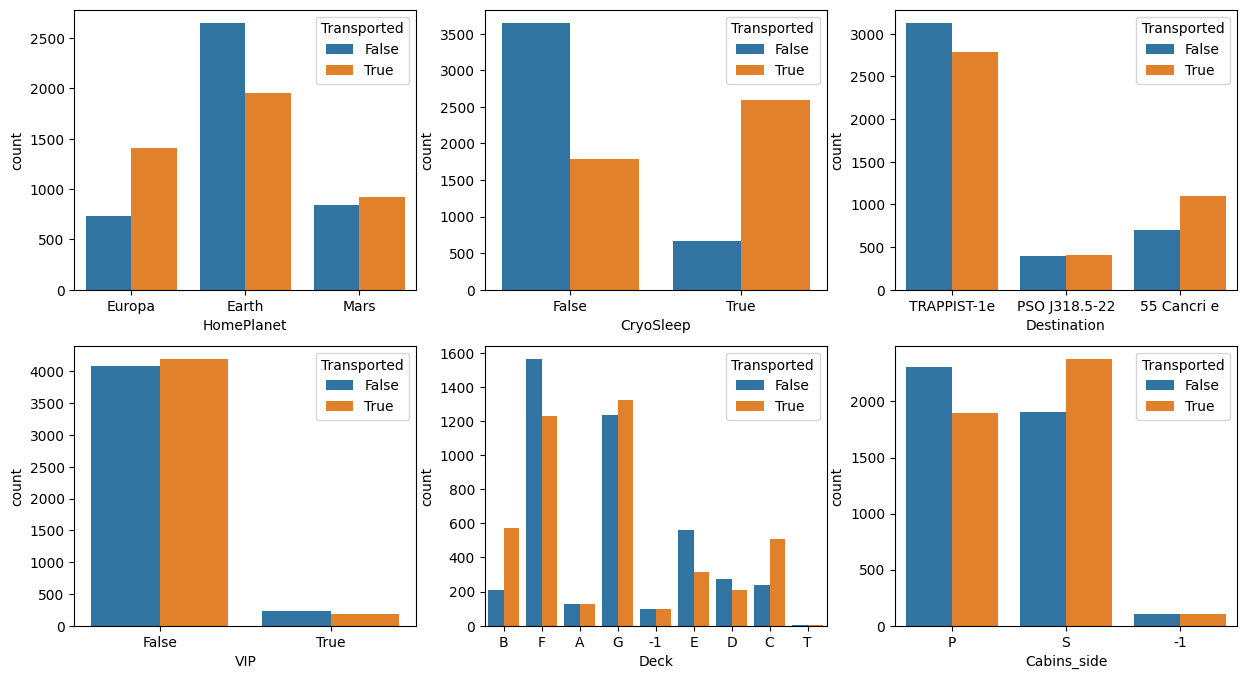

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
axes = axes.ravel()
for i, col in enumerate(class_cols[:-1]):
    sns.countplot(data=df, x=col, hue='Transported', ax=axes[i])

/tmp/ipykernel_12492/2208582722.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.query("~Transported.isna()").corr(method="spearman"), annot=True);


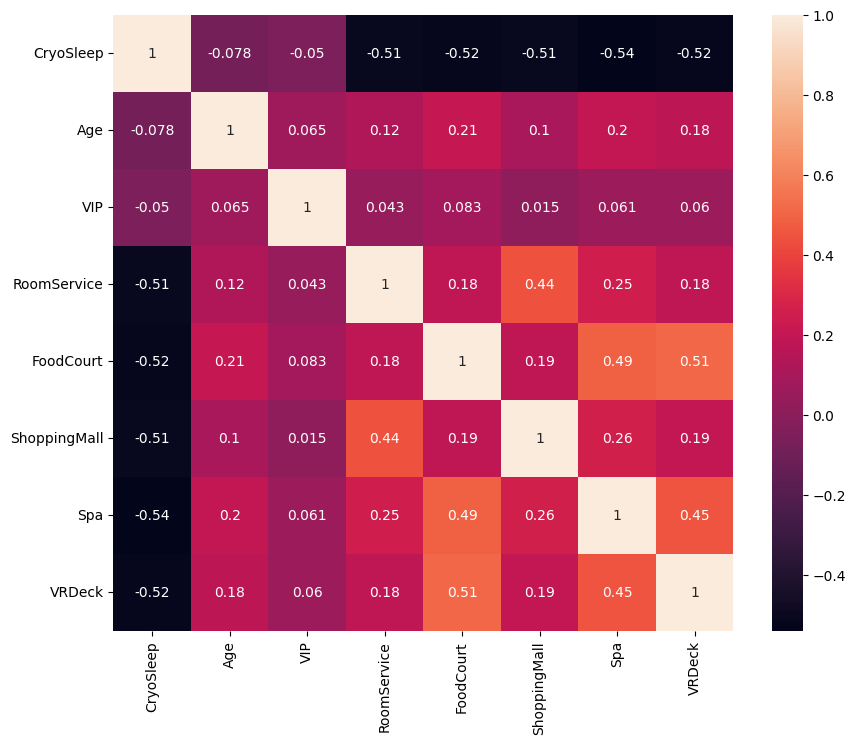

In [16]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.query("~Transported.isna()").corr(method="spearman"), annot=True);

In [17]:
df.query('CryoSleep == True').describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,4774.000000,4795.000000,4779.000000,4750.000000,4777.000000,4792.000000
mean,27.589443,14.569969,26.508056,9.528842,20.670714,18.243322
std,14.886633,183.237918,337.563129,113.922857,356.004741,261.985893
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,78.000000,8243.000000,16263.000000,4471.000000,19844.000000,9811.000000


In [18]:
df['HomePlanet'].fillna("Earth", inplace=True)
df['Destination'].fillna("TRAPPIST-1e", inplace=True)

In [19]:
df['VIP'].fillna(False, inplace=True)

Filling service columns with 0 if CryoSleep is True

In [20]:
columns_to_fill = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
for col_to_fill in columns_to_fill:
    df.loc[(df["CryoSleep"] == True) & (df[col_to_fill].isna()), col_to_fill] = 0

Filling service columns with the median value(50%) based on HomePlanet, Destination and VIP columns

In [21]:
columns_to_fill = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
for col_to_fill in columns_to_fill:
    df_fill = df[[col_to_fill, 'HomePlanet', 'Destination', 'VIP']].groupby(by=['HomePlanet', 'Destination', 'VIP']).describe().reset_index()
    
    for row in df_fill.itertuples():
        df.loc[(df["HomePlanet"] == row[1]) & (df["Destination"] == row[2]) & (df["VIP"] == row[3]) & (df[col_to_fill].isna()), [col_to_fill]] = row[9]

In [22]:
df['CryoSleep'].fillna(False, inplace=True)
df['Age'].fillna(27, inplace=True)

In [23]:
df['Spendings'] = df['RoomService'] + df['FoodCourt'] + df['ShoppingMall'] + df['Spa'] + df['VRDeck']

In [24]:
df[["Deck", "Cabins_side", "Spendings"]].groupby(by=["Deck", "Cabins_side"]).count()

Spendings
Deck Cabins_side           
-1   -1                 299
A    P                  166
     S                  188
B    P                  512
     S                  629
C    P                  533
     S                  569
D    P                  370
     S                  350
E    P                  641
     S                  682
F    P                 2178
     S                 2061
G    P                 1885
     S                 1896
T    P                    5
     S                    6

In [25]:
df['Deck'] = df['Deck'].apply(lambda x: "F" if x == '-1' else x)
df['Cabins_side'] = df['Cabins_side'].apply(lambda x: "P" if x == '-1' else x)
df['Cabins_side'] = df['Cabins_side'].apply(lambda x: 1 if x == 'P' else 0)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12970 entries, 0 to 4276
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    12970 non-null  object 
 1   CryoSleep     12970 non-null  bool   
 2   Destination   12970 non-null  object 
 3   Age           12970 non-null  float64
 4   VIP           12970 non-null  bool   
 5   RoomService   12970 non-null  float64
 6   FoodCourt     12970 non-null  float64
 7   ShoppingMall  12970 non-null  float64
 8   Spa           12970 non-null  float64
 9   VRDeck        12970 non-null  float64
 10  Transported   8693 non-null   object 
 11  Deck          12970 non-null  object 
 12  Cabins_side   12970 non-null  int64  
 13  Spendings     12970 non-null  float64
dtypes: bool(2), float64(7), int64(1), object(4)
memory usage: 1.3+ MB


In [27]:
df['Transported'] = df['Transported'].apply(lambda x: int(x) if type(x) == bool else x)

/tmp/ipykernel_12492/2208582722.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.query("~Transported.isna()").corr(method="spearman"), annot=True);


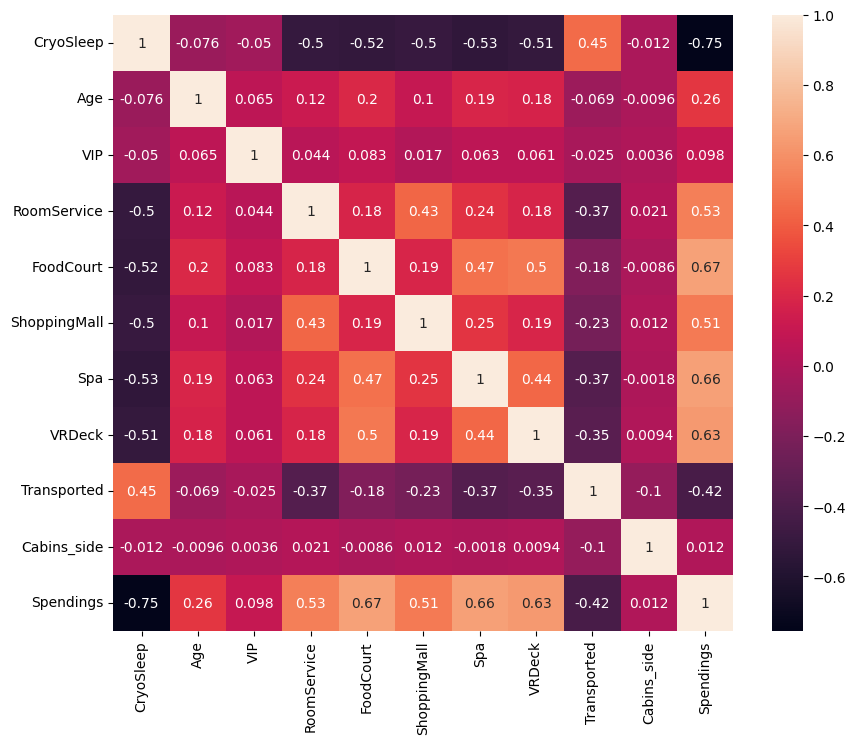

In [28]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.query("~Transported.isna()").corr(method="spearman"), annot=True);

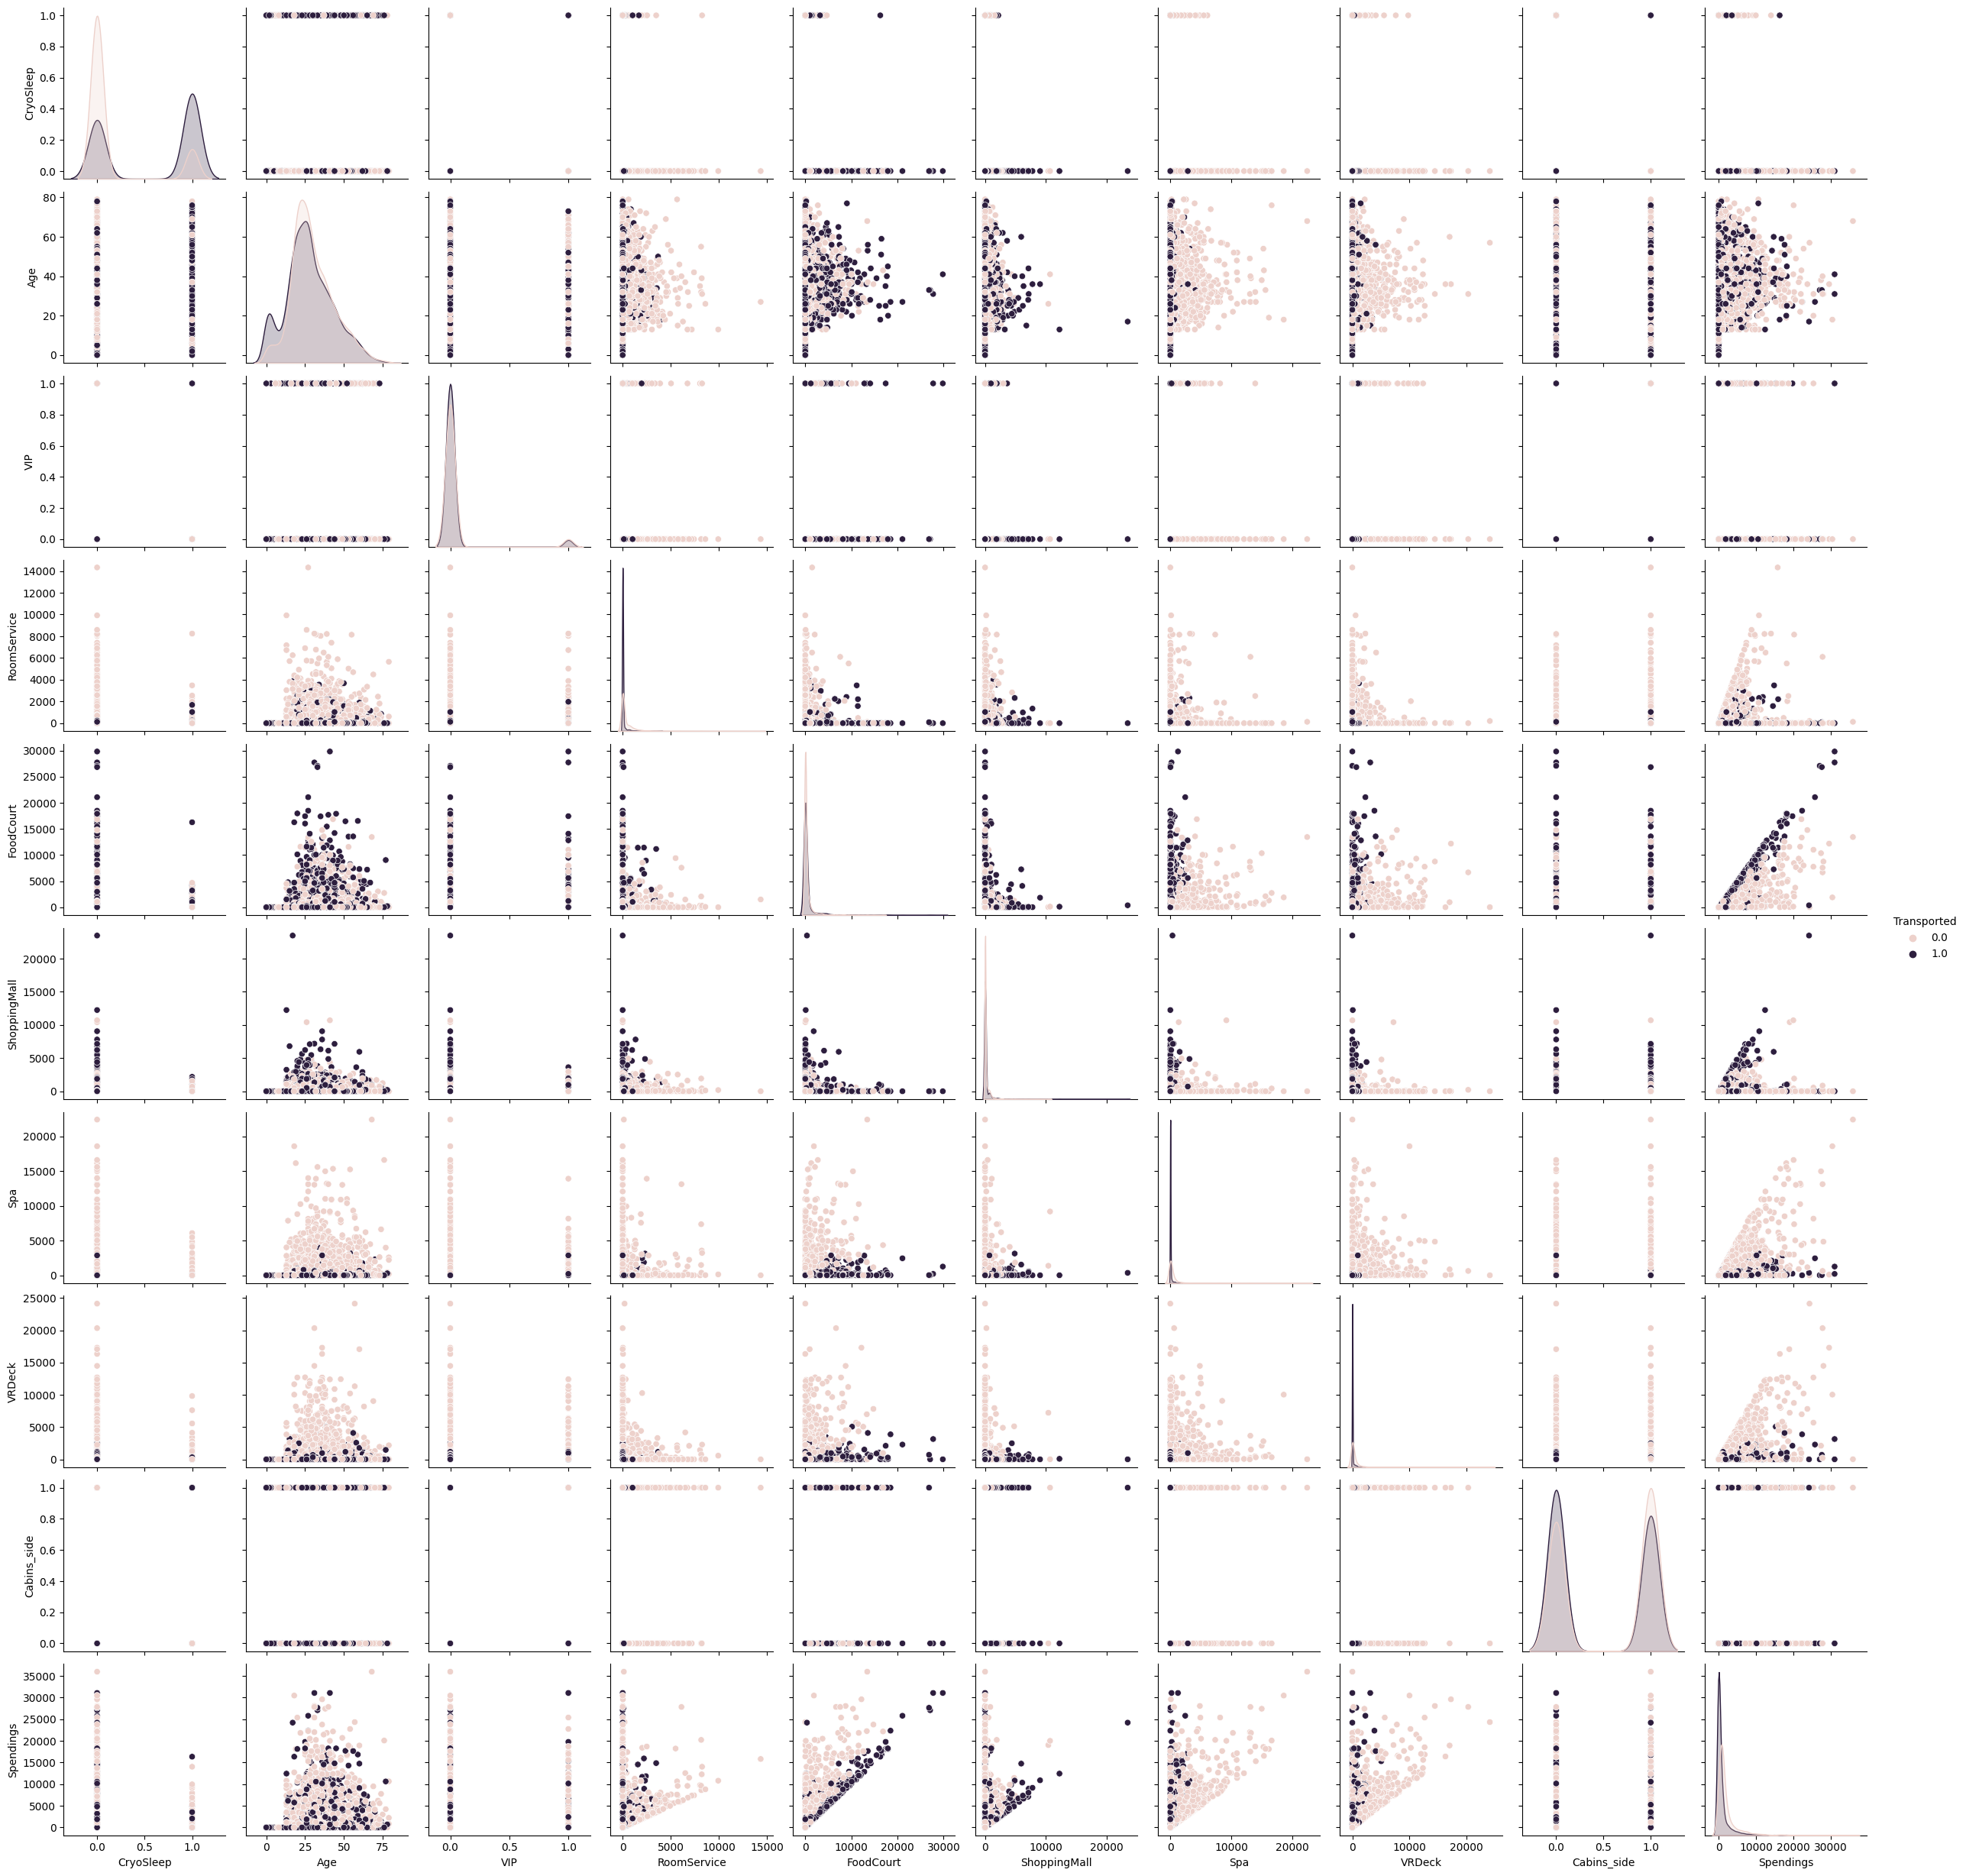

In [29]:
sns.pairplot(data=df, hue='Transported');

In [30]:
df = pd.get_dummies(data=df, columns=['HomePlanet', 'Destination', 'Deck'])
df

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Cabins_side,...,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T
0,False,39.0,False,0.0,0.0,0.0,0.0,0.0,0.0,1,...,0,1,0,1,0,0,0,0,0,0
1,False,24.0,False,109.0,9.0,25.0,549.0,44.0,1.0,0,...,0,1,0,0,0,0,0,1,0,0
2,False,58.0,True,43.0,3576.0,0.0,6715.0,49.0,0.0,0,...,0,1,1,0,0,0,0,0,0,0
3,False,33.0,False,0.0,1283.0,371.0,3329.0,193.0,0.0,0,...,0,1,1,0,0,0,0,0,0,0
4,False,16.0,False,303.0,70.0,151.0,565.0,2.0,1.0,0,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,True,34.0,False,0.0,0.0,0.0,0.0,0.0,NaN,0,...,0,1,0,0,0,0,0,0,1,0
4273,False,42.0,False,0.0,847.0,17.0,10.0,144.0,NaN,1,...,0,1,0,0,0,0,0,1,0,0
4274,True,27.0,False,0.0,0.0,0.0,0.0,0.0,NaN,1,...,0,0,0,0,0,1,0,0,0,0
4275,False,27.0,False,0.0,2680.0,0.0,0.0,523.0,NaN,1,...,0,1,0,0,0,1,0,0,0,0


In [31]:
scaler = MinMaxScaler()
scaled_cols = scaler.fit_transform(df)#[num_cols]
scaled_df = pd.DataFrame(scaled_cols, columns=df.columns)#num_cols
scaled_df

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Cabins_side,...,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T
0,0.0,0.493671,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.303797,0.0,0.007608,0.000302,0.001064,0.024500,0.001823,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.734177,1.0,0.003001,0.119948,0.000000,0.299670,0.002030,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.417722,0.0,0.000000,0.043035,0.015793,0.148563,0.007997,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.202532,0.0,0.021149,0.002348,0.006428,0.025214,0.000083,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,1.0,0.430380,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
12966,0.0,0.531646,0.0,0.000000,0.028410,0.000724,0.000446,0.005967,NaN,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
12967,1.0,0.341772,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
12968,0.0,0.341772,0.0,0.000000,0.089894,0.000000,0.000000,0.021672,NaN,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [32]:
df_train = scaled_df.query("~Transported.isna()")
df_test = scaled_df.query("Transported.isna()")

## Prediction

In [33]:
x = df_train.drop(columns='Transported')
y = df_train['Transported']

### Gridsearch

In [39]:
#mlflow.set_tracking_uri(f'mysql://{credentials.user}:{credentials.pwd}@{credentials.host}/{credentials.db}')
mlflow.set_tracking_uri('http://127.0.0.1:5000')

#### Random Forest

In [38]:
params = {'n_estimators': [100, 200, 300], 'criterion': ['gini', 'entropy', 'log_loss'], 'min_samples_split': [2, 4, 6, 8, 10], 'min_samples_leaf': [1, 2, 3, 4, 5, 6],
          'max_features': ['sqrt', 'log2', 0.25, 0.5, 0.75, 1], 'bootstrap': [True, False]}
scoring = ['accuracy', 'f1', 'roc_auc']

model = RandomForestClassifier()

grid_search = GridSearchCV(model, param_grid=params, cv=10, scoring=scoring, refit=scoring[0], n_jobs=11)
grid_search.fit(x, y)

print(grid_search.best_params_)
print("Accuracy for Random Forest", grid_search.best_score_)

{'bootstrap': True, 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 6, 'min_samples_split': 8, 'n_estimators': 100}
Accuracy for Random Forest 0.8039876724468605


In [40]:
mlflow.set_experiment("Random Forest")
for i, p in enumerate(grid_search.cv_results_['params']):
    with mlflow.start_run():
        mlflow.log_params(p)
        metrics = {"auc": grid_search.cv_results_['mean_test_accuracy'][i], "f1": grid_search.cv_results_['mean_test_f1'][i], "accuracy": grid_search.cv_results_['mean_test_accuracy'][i]}
        mlflow.log_metrics(metrics)
    mlflow.end_run()

2023/02/08 18:10:34 INFO mlflow.tracking.fluent: Experiment with name 'Random Forest' does not exist. Creating a new experiment.


#### Ada Boost

In [44]:
params = {'n_estimators': [50, 100, 150, 200, 250], 'estimator': [DecisionTreeClassifier(max_depth=i) for i in range(1, 6)], 'learning_rate': [0.01, 0.1, 0.25, 0.5, 0.75, 1]}
scoring = ['accuracy', 'f1', 'roc_auc']

model = AdaBoostClassifier()

grid_search = GridSearchCV(model, param_grid=params, cv=10, scoring=scoring, refit=scoring[0], n_jobs=11)
grid_search.fit(x, y)

print(grid_search.best_params_)
print("Accuracy for Ada Boost", grid_search.best_score_)

{'estimator': DecisionTreeClassifier(max_depth=4), 'learning_rate': 0.1, 'n_estimators': 50}
Accuracy for SVC 0.8035249923944818


In [45]:
mlflow.set_experiment("Ada Boost")
for i, p in enumerate(grid_search.cv_results_['params']):
    with mlflow.start_run():
        mlflow.log_params(p)
        metrics = {"auc": grid_search.cv_results_['mean_test_accuracy'][i], "f1": grid_search.cv_results_['mean_test_f1'][i], "accuracy": grid_search.cv_results_['mean_test_accuracy'][i]}
        mlflow.log_metrics(metrics)
    mlflow.end_run()

2023/02/08 18:22:27 INFO mlflow.tracking.fluent: Experiment with name 'Ada Boost' does not exist. Creating a new experiment.


#### Gradient Boosting

In [51]:
params = {'n_estimators': [100, 200, 300], 'criterion': ['friedman_mse', 'squared_error'], 'min_samples_split': [2, 4, 6, 8], 
          'min_samples_leaf': [1, 2, 3, 4, 5, 6], 'max_features': ['sqrt', 'log2', 0.25, 0.5, 0.75, 1], 'learning_rate': [0.01, 0.1, 0.25, 0.5, 0.75, 1]}
scoring = ['accuracy', 'f1', 'roc_auc']

model = GradientBoostingClassifier()

grid_search = GridSearchCV(model, param_grid=params, cv=10, scoring=scoring, refit=scoring[0], n_jobs=11)
grid_search.fit(x, y)

print(grid_search.best_params_)
print("Accuracy for Gradient Boosting", grid_search.best_score_)

{'criterion': 'squared_error', 'learning_rate': 0.25, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 300}
Accuracy for Gradient Boosting 0.8087036228721083


In [52]:
mlflow.set_experiment("Gradient Boosting")
for i, p in enumerate(grid_search.cv_results_['params']):
    with mlflow.start_run():
        mlflow.log_params(p)
        metrics = {"auc": grid_search.cv_results_['mean_test_accuracy'][i], "f1": grid_search.cv_results_['mean_test_f1'][i], "accuracy": grid_search.cv_results_['mean_test_accuracy'][i]}
        mlflow.log_metrics(metrics)
    mlflow.end_run()

2023/02/08 21:03:42 INFO mlflow.tracking.fluent: Experiment with name 'Gradient Boosting' does not exist. Creating a new experiment.


#### Logistic Regression

In [63]:
params = {'penalty': [None, 'l1', 'l2', 'elasticnet'], 'solver': ['lbfgs', 'liblinear', 'newton-cholesky', 'sag', 'saga'], 'max_iter': [9999]}
scoring = ['accuracy', 'f1', 'roc_auc']

model = LogisticRegression()

grid_search = GridSearchCV(model, param_grid=params, cv=10, scoring=scoring, refit=scoring[0])
grid_search.fit(x, y)

print(grid_search.best_params_)
print("Accuracy for Logistic Regression", grid_search.best_score_)

/home/daniel/miniconda3/envs/titanic/lib/python3.9/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=1.17293e-19): result may not be accurate.
  warnings.warn(
/home/daniel/miniconda3/envs/titanic/lib/python3.9/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies a

{'max_iter': 9999, 'penalty': None, 'solver': 'newton-cholesky'}
Accuracy for Logistic Regression 0.7881107892543946


/home/daniel/miniconda3/envs/titanic/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
90 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/home/daniel/miniconda3/envs/titanic/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/daniel/miniconda3/envs/titanic/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1216, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "/home/daniel/miniconda3/envs/titanic/lib/python3.9/site-packages/s

In [66]:
mlflow.set_experiment("Logistic Regression 1")
for i, p in enumerate(grid_search.cv_results_['params']):
    with mlflow.start_run():
        mlflow.log_params(p)
        metrics = {"auc": grid_search.cv_results_['mean_test_accuracy'][i], "f1": grid_search.cv_results_['mean_test_f1'][i], "accuracy": grid_search.cv_results_['mean_test_accuracy'][i]}
        mlflow.log_metrics(metrics)
    mlflow.end_run()

2023/02/08 21:55:34 INFO mlflow.tracking.fluent: Experiment with name 'Logistic Regression 1' does not exist. Creating a new experiment.


#### SVC

In [72]:
params = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'degree': [2, 3, 4, 5, 6],
          'gamma': ['scale', 'auto'], 'shrinking': [False, True]}
scoring = ['accuracy', 'f1', 'roc_auc']

model = SVC()

grid_search = GridSearchCV(model, param_grid=params, cv=10, scoring=scoring, refit=scoring[0], n_jobs=11)
grid_search.fit(x, y)

print(grid_search.best_params_)
print("Accuracy for SVC", grid_search.best_score_)

{'degree': 4, 'gamma': 'scale', 'kernel': 'poly', 'shrinking': False}
Accuracy for SVC 0.7606153194979035


In [73]:
mlflow.set_experiment("SVC 1")
for i, p in enumerate(grid_search.cv_results_['params']):
    with mlflow.start_run():
        mlflow.log_params(p)
        metrics = {"auc": grid_search.cv_results_['mean_test_accuracy'][i], "f1": grid_search.cv_results_['mean_test_f1'][i], "accuracy": grid_search.cv_results_['mean_test_accuracy'][i]}
        mlflow.log_metrics(metrics)
    mlflow.end_run()

2023/02/09 01:38:59 INFO mlflow.tracking.fluent: Experiment with name 'SVC 1' does not exist. Creating a new experiment.


#### CatBoost

In [70]:
params = {'n_estimators': [100, 200, 300, 400], 'learning_rate': [0.01, 0.1, 0.25, 0.5, 0.75, 1],
          'max_depth': [4, 5, 6, 7, 8, 9, 10], 'l2_leaf_reg': [15, 20, 25, 30, 35, 40, 45, 50], 'silent': [True]}
scoring = ['accuracy', 'f1', 'roc_auc']

model = CatBoostClassifier()

grid_search = GridSearchCV(model, param_grid=params, cv=10, scoring=scoring, refit="accuracy")
grid_search.fit(x, y)

print(grid_search.best_params_)
print("Accuracy for CatBoost", grid_search.best_score_)

{'l2_leaf_reg': 20, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 300, 'silent': True}
Accuracy for CatBoost 0.8135341190164411


In [71]:
mlflow.set_experiment("Catboost")
for i, p in enumerate(grid_search.cv_results_['params']):
    with mlflow.start_run():
        mlflow.log_params(p)
        metrics = {"auc": grid_search.cv_results_['mean_test_accuracy'][i], "f1": grid_search.cv_results_['mean_test_f1'][i], "accuracy": grid_search.cv_results_['mean_test_accuracy'][i]}
        mlflow.log_metrics(metrics)
    mlflow.end_run()

2023/02/09 01:34:05 INFO mlflow.tracking.fluent: Experiment with name 'Catboost' does not exist. Creating a new experiment.


## Submition

In [86]:
model = CatBoostClassifier(l2_leaf_reg=19, learning_rate=0.1, max_depth=8, n_estimators=300, verbose=False)
model.fit(df_train.drop(columns='Transported'), df_train['Transported'])

In [82]:
y_pred = model.predict(df_test.drop(columns='Transported'))

In [83]:
df_submit = pd.DataFrame({'PassengerId': passager_id, 'Transported': y_pred})
df_submit['Transported'] = df_submit['Transported'].astype(bool)

In [84]:
df_submit

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [85]:
df_submit.to_csv('submit.csv', index=False)